In [198]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def cond_interp(cond_u,u,rate,pos,bins=100,av=6):  
    '''
    Interpolates the inverse CCDF
    cond_u: conditioned variable from [0,1]
    u: a variable prior to conditioning [0,1]
    rate: a firing rate that corresponds to u
    pos: conditioning variable
    bins: number of bins
    av: number of neighbouring bins that are included
        in ccdf estimation (rule of thumb:
        make higher untill fix messages disappear)
    '''
    cond_y = np.empty_like(cond_u)
    for i in range(bins):
        mask_av = (pos>=(i-av)/bins) & (pos<=(i+av+1)/bins)
        mask = (pos>=i/bins) & (pos<=(i+1)/bins)
        if cond_u[mask].min()<u[mask_av].min():
            print('Fixing min')
            cond_u[mask & (cond_u<u[mask_av].min())] = u[mask_av].min()
        if cond_u[mask].max()>u[mask_av].max():
            print('Fixing max')
            cond_u[mask & (cond_u>u[mask_av].max())] = u[mask_av].max()
        interp = interpolate.interp1d(u[mask_av],rate[mask_av],
                                    kind='slinear')
        cond_y[mask] = interp(cond_u[mask])
        if np.any(cond_y==np.inf):
            print(cond_u[cond_y==np.inf],pos[cond_y==np.inf],u[mask].min(),rate[mask].min(),u[mask].max(),rate[mask].max())
    cond_y[rate<0.01] = rate[rate<0.01] # remove transformed jitter
    assert np.all(cond_y==cond_y)
    assert np.all(cond_y!=np.inf), cond_u[cond_y==np.inf]
    return cond_y

In [199]:
# session = 'M7_D21_2020-11-26_16-09-48'
session = 'M3_D18_2020-11-21_14-29-49'
data = pd.read_pickle(f'{session}_u.pkl')
data.iloc[2]

session_id                               M3_D18_2020-11-21_14-29-49
cluster_id                                                       12
spikes_per50ms    [[0.17351680745402503, 0.2128912512133495, 0.2...
u_vel_t0          [0.06973600729436508, 0.0691285010862015, 0.07...
u_rate_t0         [0.0283606961094209, 0.030153486130715286, 0.0...
u_vel_t1          [0.0035819461196700078, 8.090774314118034e-05,...
u_rate_t1         [0.020286581043474576, 0.022004345574204814, 0...
Name: 10, dtype: object

In [299]:
session_id=20
u_vel_t0=data.iloc[session_id].u_vel_t0
u_rate_t0=data.iloc[session_id].u_rate_t0
u_vel_t1=data.iloc[session_id].u_vel_t1
u_rate_t1=data.iloc[session_id].u_rate_t1
[ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
pos_t0 = ds_pos[trial_type==0]/LENGTH
pos_t1 = ds_pos[trial_type==1]/LENGTH
ds_rate_t0 = ds_rate[trial_type==0]
ds_rate_t1 = ds_rate[trial_type==1]

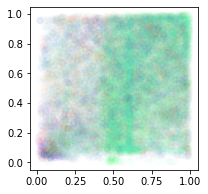

In [300]:
from matplotlib import cm
cmap = cm.rainbow
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t0,u_rate_t0,color=cmap(pos_t0),alpha=0.01)

# Gauss

In [301]:
device='cuda:0'
train_x = torch.tensor(pos_t0).float().to(device=device)
train_y = torch.tensor(np.array([u_rate_t0,u_vel_t0]).T).float().to(device=device)

likelihoods = [bvcopula.GaussianCopula_Likelihood()]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                     device=device, prior_rbf_length=1.)
print(f"WAIC: {waic}")

CPU times: user 26 s, sys: 208 ms, total: 26.2 s
Wall time: 20.6 s
WAIC: -0.049372825771570206


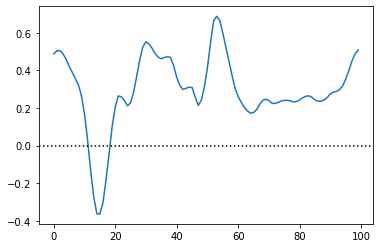

In [302]:
test_x = torch.linspace(0,1,100).float().to(device=device)
theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
plt.plot(theta)
plt.axhline(0,color='k',linestyle=':')

Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing min
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min


ValueError: x and y must have same first dimension, but have shapes (24083,) and (1000,)

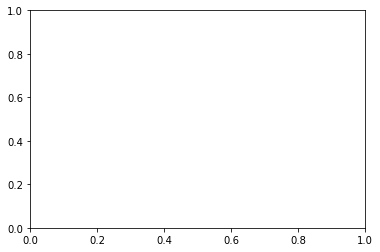

In [319]:
model.gp_model.eval()
# copula = model.marginalize(train_x) # marginalize the GP
with torch.no_grad():
    f = model.gp_model(train_x).mean
copula = model.likelihood.get_copula(f) 
cond_u = copula.ccdf(train_y).cpu().numpy()
cond_y = cond_interp(cond_u,u_rate_t0,ds_rate_t0,pos_t0,av=5)

plt.plot(pos_t0,ds_rate_t0[1000:2000])
plt.plot(pos_t0,cond_y[1000:2000])
# rate_HPC[::200,5].shape
# cond_u.shape

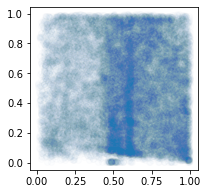

In [320]:
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t0,cond_u,alpha=0.01)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, '')

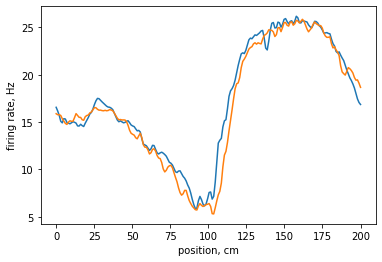

In [321]:
n_bins = 200
m=5
averages = np.empty((2,n_bins))
for i in tqdm(range(n_bins)):
    mask = (pos_t0>=(i-m)/n_bins) & (pos_t0 <=(i+1+m)/n_bins)
    w = np.exp(-(pos_t0[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
    w = w/w.sum()
#     print(w)
    averages[0,i] =  20*(ds_rate_t0[mask] * w).sum()
    averages[1,i] =  20*(cond_y[mask] * w).sum()
plt.plot(np.linspace(0,LENGTH,n_bins),averages.T)
plt.xlabel('position, cm')
plt.ylabel('firing rate, Hz')
plt.title('')

# Many

0it [00:00, ?it/s]

CPU times: user 18 s, sys: 244 ms, total: 18.3 s
Wall time: 12.6 s
WAIC: -0.008333161473274231
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 8.34 s, sys: 36 ms, total: 8.37 s
Wall time: 8.36 s
WAIC: -0.015276127494871616
Fixing max
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 26.2 s, sys: 177 ms, total: 26.3 s
Wall time: 20.7 s
WAIC: -0.024638576433062553


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.8 s, sys: 52.3 ms, total: 18.8 s
Wall time: 18.8 s
WAIC: -0.06555786728858948
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

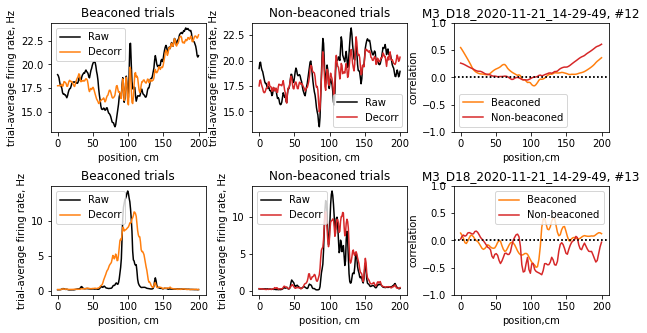

In [251]:
fig, axes = plt.subplots(2,3,figsize=(10,5))
device='cuda:0'
n_bins = 200
m=5
test_x = torch.linspace(0,1,100).float().to(device=device)
for ax, session_id in tqdm(zip(axes,[2,3])):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    train_x = torch.tensor(pos_t0).float().to(device=device)
    train_y = torch.tensor(np.array([u_rate_t0,u_vel_t0]).T).float().to(device=device)

    likelihoods = [bvcopula.GaussianCopula_Likelihood()]
    %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
    print(f"WAIC: {waic}")
    
    model.gp_model.eval()
    with torch.no_grad():
        f = model.gp_model(train_x).mean
    copula = model.likelihood.get_copula(f) 
    cond_u = copula.ccdf(train_y).cpu().numpy()
    cond_y = cond_interp(cond_u,u_rate_t0,ds_rate_t0,pos_t0,bins=50)
    
    theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta,label='Beaconed',c='C1')
    ax[2].axhline(0,color='k',linestyle=':')
    
    averages = np.empty((2,n_bins))
    for i in tqdm(range(n_bins)):
        mask = (pos_t0>=(i-m)/n_bins) & (pos_t0 <=(i+1+m)/n_bins)
        w = np.exp(-(pos_t0[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
        w = w/w.sum()
        averages[0,i] =  20*(ds_rate_t0[mask] * w).sum()
        averages[1,i] =  20*(cond_y[mask] * w).sum()
    for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C1'])):
        ax[0].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
    ax[0].set_xlabel('position, cm')
    ax[0].set_ylabel('trial-average firing rate, Hz')
    ax[0].set_title('Beaconed trials')
    ax[0].legend()
    
    train_x = torch.tensor(pos_t1).float().to(device=device)
    train_y = torch.tensor(np.array([u_rate_t1,u_vel_t1]).T).float().to(device=device)

    likelihoods = [bvcopula.GaussianCopula_Likelihood()]
    %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
    print(f"WAIC: {waic}")
    
    model.gp_model.eval()
    with torch.no_grad():
        f = model.gp_model(train_x).mean
    copula = model.likelihood.get_copula(f) 
    cond_u = copula.ccdf(train_y).cpu().numpy()
    cond_y = cond_interp(cond_u,u_rate_t1,ds_rate_t1,pos_t1,bins=50)
    
    theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta,label='Non-beaconed',c='C3')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].set_ylim([-1,1])
    ax[2].set_xlabel('position,cm')
    ax[2].set_ylabel('correlation')
    ax[2].set_title(f'{session}, #{data.iloc[session_id].cluster_id}')
    ax[2].legend()
    
    averages = np.empty((2,n_bins))
    for i in tqdm(range(n_bins)):
        mask = (pos_t1>=(i-m)/n_bins) & (pos_t1 <=(i+1+m)/n_bins)
        w = np.exp(-(pos_t1[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
        w = w/w.sum()
        averages[0,i] =  20*(ds_rate_t1[mask] * w).sum()
        averages[1,i] =  20*(cond_y[mask] * w).sum()
    for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C3'])):
        ax[1].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
    ax[1].set_xlabel('position, cm')
    ax[1].set_ylabel('trial-average firing rate, Hz')
    ax[1].set_title('Non-beaconed trials')
    ax[1].legend()
fig.subplots_adjust(wspace=0.3,hspace=0.5)

In [246]:
likelihoods = [bvcopula.GaussianCopula_Likelihood()]
WAICs, thetas, cond_y = [None for _ in range(len(data))],\
                        [None for _ in range(len(data))],\
                        [None for _ in range(len(data))]
for session_id in tqdm([2]):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    WAICs[session_id] = [None, None]
    thetas[session_id] = [None, None]
    cond_y[session_id] = [None, None]
    
    for i, (A, u_A, rate_A, u_vel, pos) in enumerate([\
                            ("beaconed",u_rate_t0, ds_rate_t0, u_vel_t0, pos_t0), \
                            ("non-beaconed",u_rate_t1, ds_rate_t1, u_vel_t1, pos_t1)]):
                                                  
        train_x = torch.tensor(pos).float().to(device=device)
        train_y = torch.tensor(np.array([u_A,u_vel]).T).float().to(device=device)

        likelihoods = [bvcopula.GaussianCopula_Likelihood()]
        (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
        
        WAICs[session_id][i] = waic
        print(f"WAIC: {waic}")
        
        model.gp_model.eval()
        with torch.no_grad():
            f = model.gp_model(train_x).mean
        copula = model.likelihood.get_copula(f) 
        cond_u = copula.ccdf(train_y).cpu().numpy()
        cond_y[session_id][i] = cond_interp(cond_u,u_A,rate_A,pos,bins=100)
        theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
        thetas[session_id][i] = theta
    
data['Gauss_WAICs'] = WAICs
data['Gauss_theta'] = thetas
data['spikes_lin_uncorr_from_vel'] = cond_y

  0%|          | 0/1 [00:00<?, ?it/s]

WAIC: -0.008363435044884682
Fixing max
Fixing max
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
WAIC: -0.015273667871952057
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max


0it [00:00, ?it/s]

WAIC: [-0.0016254306538030505, -0.003221343271434307]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.022457875311374664, -0.04783829301595688]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.008339865133166313, -0.015278534963726997]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.02462659403681755, -0.06569335609674454]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.007122998125851154, -0.001981498207896948]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.04119817167520523, -0.07195586711168289]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.013354959897696972, -0.014329112134873867]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

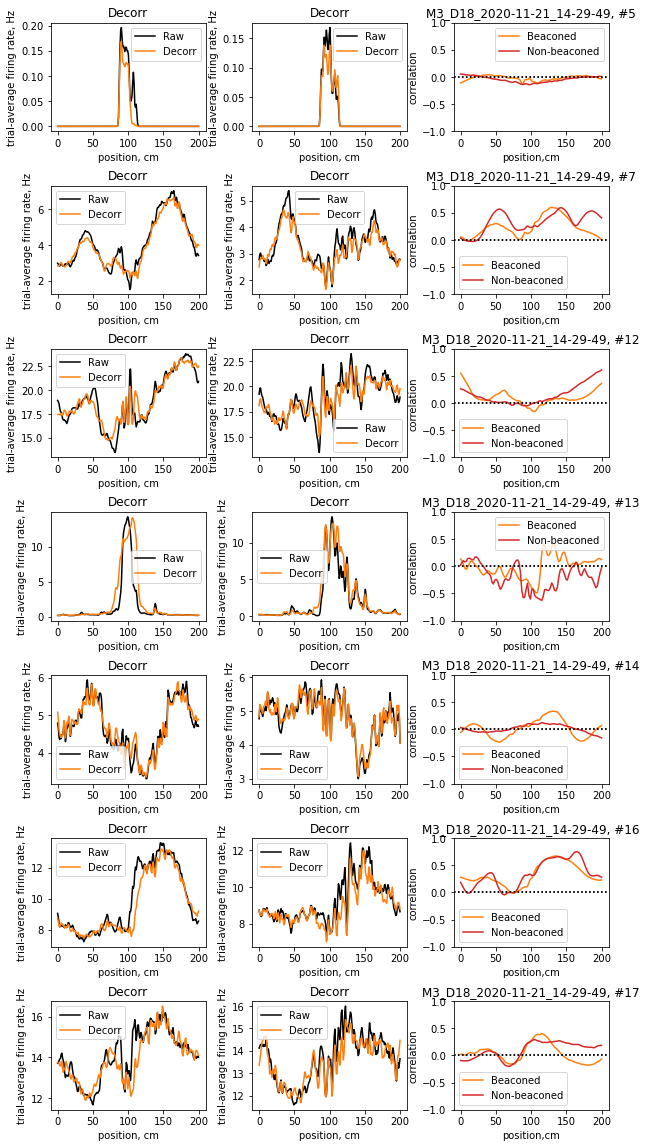

In [253]:
fig, axes = plt.subplots(7,3,figsize=(10,20))
n_bins = 200
m=5 # kernel weights for smoothing in plots, in bins
test_x = torch.linspace(0,1,100).float().to(device=device)
for ax, session_id in tqdm(zip(axes,np.arange(7))):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    waic = data.iloc[session_id].Gauss_WAICs
    theta = data.iloc[session_id].Gauss_theta
    cond_y = data.iloc[session_id].spikes_lin_uncorr_from_vel
    print(f"WAIC: {waic}")
    
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta[0],label='Beaconed',c='C1')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta[1],label='Non-beaconed',c='C3')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].set_ylim([-1,1])
    ax[2].set_xlabel('position,cm')
    ax[2].set_ylabel('correlation')
    ax[2].set_title(f'{session}, #{data.iloc[session_id].cluster_id}')
    ax[2].legend()
    
    for j, (label, pos, ds_rate) in enumerate(zip(['Beaconed trials','Non-beaconed trials'],\
                                             [pos_t0,pos_t1], [ds_rate_t0, ds_rate_t1])):
        averages = np.empty((2,n_bins))
        for i in tqdm(range(n_bins)):
            mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
            w = np.exp(-(pos[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
            w = w/w.sum()
            averages[0,i] =  20*(ds_rate[mask] * w).sum() # x 20 to get to Hz from 50ms bins
            averages[1,i] =  20*(cond_y[j][mask] * w).sum()
        for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C1'])):
            ax[j].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
        ax[j].set_xlabel('position, cm')
        ax[j].set_ylabel('trial-average firing rate, Hz')
        ax[j].set_title(label)
        ax[j].legend()
        
fig.subplots_adjust(wspace=0.3,hspace=0.5)

# Non-gauss

In [227]:
import copulagp.select_copula as select_copula

WAICs, names, cond_y =  [None for _ in range(len(data))], \
                        [None for _ in range(len(data))], \
                        [None for _ in range(len(data))]
for session_id in tqdm(range(len(data))):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    WAICs[session_id] = [None, None]
    names[session_id] = [None, None]
    cond_y[session_id] = [None, None]
    
    for i, (A, u_A, rate_A, u_vel, pos) in enumerate([\
                            ("beaconed",u_rate_t0, ds_rate_t0, u_vel_t0, pos_t0), \
                            ("non-beaconed",u_rate_t1, ds_rate_t1, u_vel_t1, pos_t1)]):

        train_x = torch.tensor(pos).float().to(device=device)
        train_y = torch.tensor([u_A,u_vel]).t().float().to(device=device)

        (store, waic) = select_copula.select_with_heuristics(pos,train_y.cpu().numpy(),device,'cond',\
                                                './',f'Cluster {session_id}','Velocity',train_x=train_x,train_y=train_y)
        WAICs[session_id][i] = waic
        names[session_id][i] = store.name_string
        print(f"Best model: {store.name_string}, WAIC: {waic}")
        with open(f"{A}_models/model{session_id}_vel.pkl","wb") as f:
            pkl.dump(store,f)
        model = store.model_init(device)

        model.gp_model.eval()
        with torch.no_grad():
            f = model.gp_model(train_x).mean
        copula = model.likelihood.get_copula(f) 
        cond_u = copula.ccdf(train_y).cpu().numpy()
        cond_y[session_id][i] = cond_interp(cond_u,u_A,rate_A,pos)
    
data['WAICs'] = WAICs
data['copula model'] = names
data['spikes_nonlin_uncorr_from_vel'] = cond_y

  0%|          | 0/23 [00:00<?, ?it/s]

Best model: Independence, WAIC: -0.0016340329311788082
Fixing min
Fixing min
Fixing min
Best model: Independence, WAIC: -0.003252783790230751
Fixing min
Fixing max
Fixing min
Fixing max
Best model: GaussianClayton0°Clayton270°, WAIC: -0.03333368897438049
Fixing max
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Best model: GaussianClayton0°, WAIC: -0.05051552504301071
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
Best model: IndependenceGaussianClayton0°, WAIC: -0.013287480920553207
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Best model: IndependenceGaussianClayton0°, WAIC: -0.02366628684103489
Fixing min
Fixing 

Best model: IndependenceGaussianClayton0°, WAIC: -0.04737162962555885
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Best model: GaussianClayton0°, WAIC: -0.08449472486972809
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing max
Fixing min
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Best model: IndependenceF

Best model: IndependenceGaussianClayton0°, WAIC: -0.029371006414294243
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Best model: FrankClayton0°, WAIC: -0.049018554389476776
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Best model: IndependenceGaussianClayton0°Clayton270°, WAIC: -0.01301941554993391
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Best model: GaussianClayton0°Clayton270°, WAIC: -0.020742621272802353
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing max


In [229]:
# data.to_pickle(f"{session}_50ms_done.pkl",)

0it [00:00, ?it/s]

WAIC: [-0.0016340329311788082, -0.003252783790230751]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.03333368897438049, -0.05051552504301071]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.013287480920553207, -0.02366628684103489]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.03753463923931122, -0.07304432988166809]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.011160515248775482, -0.0019864076748490334]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.04737162962555885, -0.08449472486972809]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.016059136018157005, -0.016333311796188354]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

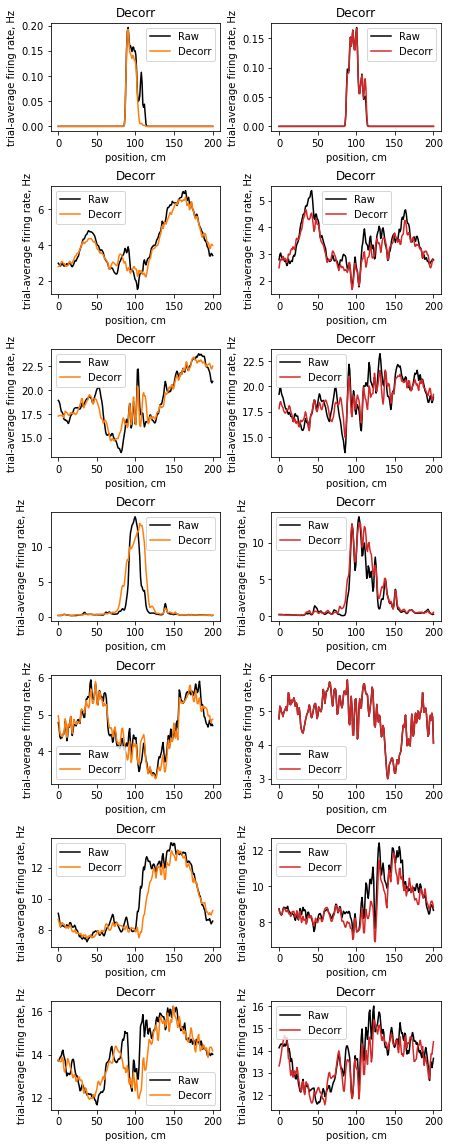

In [322]:
fig, axes = plt.subplots(7,2,figsize=(7,20))
n_bins = 200
m=5 # kernel weights for smoothing in plots, in bins
test_x = torch.linspace(0,1,100).float().to(device=device)
for ax, session_id in tqdm(zip(axes,np.arange(0,7))):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    waic = data.iloc[session_id].WAICs
    cond_y = data.iloc[session_id].spikes_nonlin_uncorr_from_vel
    print(f"WAIC: {waic}")
    
    for j, (label, pos, ds_rate, color) in enumerate(zip(['Beaconed trials','Non-beaconed trials'],\
                                             [pos_t0,pos_t1], [ds_rate_t0, ds_rate_t1], ['C1','C3'])):
        averages = np.empty((2,n_bins))
        for i in tqdm(range(n_bins)):
            mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
            w = np.exp(-(pos[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
            w = w/w.sum()
            averages[0,i] =  20*(ds_rate[mask] * w).sum() # x 20 to get to Hz from 50ms bins
            averages[1,i] =  20*(cond_y[j][mask] * w).sum()
        for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k',color])):
            ax[j].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
        ax[j].set_xlabel('position, cm')
        ax[j].set_ylabel('trial-average firing rate, Hz')
        ax[j].set_title(label)
        ax[j].legend()
        
fig.subplots_adjust(wspace=0.3,hspace=0.5)

In [252]:
data = pd.read_pickle(f'{session}_50ms_done.pkl')

In [260]:
b = [[a.max() for a in data.iloc[i].Gauss_theta] for i in range(23)]
b

[[0.041253272, 0.052320845],
 [0.60112464, 0.59422135],
 [0.5517469, 0.61038184],
 [0.41072524, 0.17231339],
 [0.3313166, 0.12061051],
 [0.66981757, 0.74618316],
 [0.40128306, 0.29444078],
 [0.13177814, 0.012689962],
 [0.39311197, 0.25222147],
 [0.16360573, 0.46497983],
 [0.05547838, 0.017208794],
 [0.4095151, 0.53841835],
 [0.2641431, 0.12992133],
 [0.46635547, 0.4423513],
 [0.50947165, 0.43325612],
 [0.30110335, 0.67821056],
 [0.2803107, 0.2825147],
 [0.25292733, 0.3878094],
 [0.0957271, 0.059673306],
 [0.38770482, 0.38684973],
 [0.6875641, 0.5432673],
 [0.37142593, 0.4277516],
 [0.24433541, 0.42727977]]